In [44]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score , hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time



In [10]:
class MyDecisionTreeClassifier:
    def __init__(self):
        self.model = DecisionTreeClassifier()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLogisticClassifier:
    def __init__(self, num_classes=9, learning_rate=0.005, num_epochs=5000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_pred.shape[0]
        return -np.sum(np.log(y_pred) * y_true) / m

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self.weights = np.zeros((n, self.num_classes))
        self.bias = np.zeros((1, self.num_classes))

        for epoch in range(self.num_epochs):
            z = np.dot(X_train, self.weights) + self.bias
            y_pred = self.softmax(z)

            y_train_encoded = np.eye(self.num_classes)[y_train]  # One-hot encoding
            loss = self.cross_entropy_loss(y_pred, y_train_encoded)

            dz = y_pred - y_train_encoded
            dw = np.dot(X_train.T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)

class MyMLPClassifier(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 12, hiddenLayerSize = [21] , outputLayerSize: int = 9):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'SGD'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights)-1)
        
        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0,len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i+1] = np.dot(self.a[i],self.weights[i+1])
        yHat = self.softmax(self.z[-1])
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = -np.sum(y * np.log(self.yHat)) / len(X)
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = self.yHat - y
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas)-2,-1,-1):
            dJdWs[i+1] = np.dot(self.a[i].T, deltas[i+1])
            deltas[i] = np.dot(deltas[i+1],self.weights[i+1].T)*self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on MLP Classifier for WineQT Dataset")
        for i in range(self.max_iterations):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        # return yHat
        binary_predictions = np.zeros_like(yHat)
        binary_predictions[np.arange(len(yHat)), yHat.argmax(axis=1)] = 1
        return binary_predictions
        # return np.argmax(yHat, axis=1)
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)


In [11]:
class MyDecisionTreeRegressor:
    def __init__(self):
        self.model = DecisionTreeRegressor(random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class MyLinearRegressor:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0
        # print(X.T)
        # Closed-form solution for linear regression
        X_transpose = X.T
        X = np.array(X)
        y = np.array(y)
        # print(y.shape)
        # print(X.shape)
        # print(X_transpose)
        self.weights = np.dot(np.linalg.inv(np.dot(X_transpose, X)), np.dot(X_transpose, y))
        # print(self.weights)
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return linear_model
    
class MyMLPRegressor(object):
    def __init__(self, learning_rate=0.001,epochs = 5000, inputLayerSize: int = 13, hiddenLayerSize = [13,13,13,13,13,13,13,13,13] , outputLayerSize: int = 1):
        self.inputLayerSize = inputLayerSize
        self.outputLayerSize = outputLayerSize
        self.hiddenLayerSize = hiddenLayerSize
        self.activation = self.sigmoid
        self.activationPrime = self.sigmoidPrime
        self.learning_rate = learning_rate
        # Weights (parameters)
        self.num_layers = len(hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        self.optimizer = 'MiniBatch'
        self.max_iterations = epochs

    def forward(self, X):
        self.z = [None] * (len(self.weights))
        self.a = [None] * (len(self.weights) - 1)

        self.z[0] = np.dot(X, self.weights[0])
        for i in range(0, len(self.a)):
            self.a[i] = self.activation(self.z[i])
            self.z[i + 1] = np.dot(self.a[i], self.weights[i + 1])
        yHat = self.z[-1]  # Linear activation for regression
        return yHat

    def relu(self, z):
        return np.maximum(0, z)  # ReLU activation

    def tanh(self, z):
        return np.tanh(z)  # Tanh activation

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoidPrime(self, z):
        return np.exp(-z) / ((1 + np.exp(-z))**2)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))  # Subtracting max(z) for numerical stability
        return exp_z / exp_z.sum(axis=1, keepdims=True)

    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = np.sum((y - self.yHat) ** 2) / (2 * len(X))  # Mean Squared Error
        return J

    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        deltas = [None] * (len(self.weights))
        deltas[-1] = -(y - self.yHat)
        dJdWs = [None] * (len(self.weights))
        for i in range(len(deltas) - 2, -1, -1):
            dJdWs[i + 1] = np.dot(self.a[i].T, deltas[i + 1])
            deltas[i] = np.dot(deltas[i + 1], self.weights[i + 1].T) * self.activationPrime(self.z[i])
        dJdWs[0] = np.dot(X.T, deltas[0])
        return dJdWs

    def reluPrime(self, z):
        return np.where(z > 0, 1, 0)  # Derivative of ReLU

    def tanhPrime(self, z):
        return 1 - np.tanh(z)**2  # Derivative of Tanh

    def backward(self, X, y, learning_rate):
        dJdWs = self.costFunctionPrime(X, y)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dJdWs[i]
        # self.W1 -= learning_rate * dJdW1
        # self.W2 -= learning_rate * dJdW2
    def fit(self, X, y, batch_size = 32, learning_rate=0.1, max_iterations=10000,wand = 0):
        if(self.optimizer == 'SGD'):
            return self.train_sgd(X=X, y=y,wand=wand)
        elif(self.optimizer == 'Batch'):
            return self.train_batch(X=X, y=y,wand=wand)
        elif(self.optimizer == 'MiniBatch'):
            return self.train_mini_batch(X=X, y=y,wand=wand)
    def train_sgd(self, X, y, learning_rate=0.1, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            idx = np.random.randint(len(X))
            self.backward(X[idx:idx+1], y[idx:idx+1], self.learning_rate)
            if i % 100 == 0:
                loss = self.costFunction(X, y)
                print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_batch(self, X, y, learning_rate=0.0001, max_iterations=10000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            self.backward(X, y, self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")
    def train_mini_batch(self, X, y, batch_size=32, learning_rate=0.01, max_iterations=5000, wand = 0):
        if(wand == 1):
            wandb.init(project="Reporting loss on Housing Dataset in MLP Regression")
        for i in range(self.max_iterations):
            # Randomly shuffle the data and split into mini-batches
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for j in range(0, len(X), batch_size):
                batch_indices = indices[j:j+batch_size]
                self.backward(X[batch_indices], y[batch_indices], self.learning_rate)
            if i % 1 == 0:
                loss = self.costFunction(X, y)
                # print("Iteration %d: loss = %f" % (i, loss))
                if(wand == 1):
                    wandb.log({"Loss": loss, "Epoch": i})
        loss = self.costFunction(X, y)
        return loss
        print("Training completed.")

    def predict(self, X):
        yHat = self.forward(X)
        return yHat
    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_activation_function(self, activation_function):
        if(activation_function == 'sigmoid'):
            self.activation = self.sigmoid
            self.activationPrime = self.sigmoidPrime
        if(activation_function == 'relu'):
            self.activation = self.relu
            self.activationPrime = self.reluPrime
        if(activation_function == 'tanh'):
            self.activation = self.tanh
            self.activationPrime = self.tanhPrime

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_hidden_layers(self, hidden_layer_sizes):
        self.hiddenLayerSize = hidden_layer_sizes
        self.num_layers = len(self.hiddenLayerSize)+1
        self.weights = []
        self.weights.append(np.random.randn(self.inputLayerSize, self.hiddenLayerSize[0]))
        for i in range(1,self.num_layers-1):
            self.weights.append(np.random.randn(self.hiddenLayerSize[i-1], self.hiddenLayerSize[i]))
        self.weights.append(np.random.randn(self.hiddenLayerSize[-1], self.outputLayerSize))
        # self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        # self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
        # self.weights, self.biases = self.initialize_weights()
    def set_epochs(self, epcohs):
        self.max_iterations = epochs
        print(self.max_iterations)






In [21]:
data = pd.read_csv('HousingData.csv')
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data = data.fillna(data.mean())
X = data.drop(columns=['MEDV'])
y = data['MEDV']
# X = data.iloc[1:, :-1].reset_index(drop=True)
# y = data.iloc[1:, -1].reset_index(drop=True)

# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




In [22]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_std = std_scaler.fit_transform(X_train)
X_val_std = std_scaler.transform(X_val)
X_test_std = std_scaler.transform(X_test)

X_train_norm = minmax_scaler.fit_transform(X_train_std)
X_val_norm = minmax_scaler.transform(X_val_std)
X_test_norm = minmax_scaler.transform(X_test_std)
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
print(X_train)
print(y_train)

[[5.18056442e-04 3.47368421e-01 3.65623822e-02 ... 6.17021277e-01
  9.91833629e-01 1.43487859e-01]
 [2.97300779e-04 2.63157895e-01 1.37580098e-01 ... 6.80851064e-01
  9.84123764e-01 1.59492274e-01]
 [1.74592552e-03 2.31578947e-01 1.75273276e-01 ... 6.91489362e-01
  9.43723054e-01 2.14955850e-01]
 ...
 [6.68786251e-05 8.42105263e-01 3.01545420e-02 ... 4.68085106e-01
  9.84884606e-01 1.17549669e-01]
 [1.25342233e-01 0.00000000e+00 6.36637769e-01 ... 8.08510638e-01
  2.72001014e-01 5.94370861e-01]
 [2.46945108e-03 0.00000000e+00 2.77044855e-01 ... 8.82978723e-01
  1.72964748e-01 2.45584989e-01]]
[36.1 22.9 24.5 25.  50.  34.9 31.7 24.1 22.1 14.1 42.8 19.3 32.2 26.4
 21.8 21.7  8.3 46.7 43.1 31.5 10.5 16.7 20.  33.3 17.8 50.  20.5 23.2
 13.1 19.6 22.8 28.7 30.7 22.9 21.9 23.9 32.7 24.3 21.5 24.6  8.5 26.4
 23.1 15.   8.8 19.3 23.9 24.7 19.8 23.8 13.3 29.  27.1 34.6 13.3 15.6
 12.5 14.6 11.  24.8 17.3  8.1 21.4 15.6 23.3 32.  38.7 30.1 20.5 32.5
 42.3 24.3 20.6 22.  18.2 15.   6.3 20.1 21.4

## Random Forest Regressor

In [14]:
def random_forest_ensemble_regression(n_estimators, sample_fraction, with_replacement, voting):
    ensemble_models = []
    
    sample_size = int(sample_fraction * len(X_train))
    num_features = X_train.shape[1]
    max_features_per_split = int(num_features / 3)  # Adjust the fraction as needed
    
    for _ in range(n_estimators):
        sample_indices = np.random.choice(len(X_train), size=sample_size, replace=with_replacement)
        sample_X = X_train[sample_indices]
        sample_y = y_train[sample_indices]
        
        # Use a decision tree with max_features set to one-third of the total features
        base_model = DecisionTreeRegressor(max_features=max_features_per_split)
        base_model.fit(sample_X, sample_y)
        
        ensemble_models.append(base_model)

    def ensemble_predict(X):
        predictions = [model.predict(X) for model in ensemble_models]

        if voting == "hard":
            return np.round(np.mean(predictions, axis=0))
        elif voting == "soft":
            confidences = [1 / (mean_squared_error(y_val, model.predict(X_val)) + 1e-10) for model in ensemble_models]  
            weighted_predictions = [prediction * confidence for prediction, confidence in zip(predictions, confidences)]
            return np.sum(weighted_predictions, axis=0) / np.sum(confidences)

    return ensemble_predict

# Example usage for Random Forest
random_forest_regressor_soft = random_forest_ensemble_regression(n_estimators=1000, sample_fraction=0.75, with_replacement=True, voting="soft")
y_pred_rf = random_forest_regressor_soft(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error (Random Forest):", mse_rf)


Mean Squared Error (Random Forest): 13.24760052695804


### Hyperparameter Tuning

In [16]:
n_estimators = [1,10,50,100,500,1000]
sample_fraction = [0.15,0.25,0.5,0.75,1]
bootstrap = [True,False]
voting = ["soft","hard"]
best_mse = 10000000
best_params = []
for i in n_estimators:
    for k in sample_fraction:
        for l in bootstrap:
            for m in voting:
                bagged_regressor = random_forest_ensemble_regression(n_estimators=i, sample_fraction=k, with_replacement=l, voting=m)
                y_pred = bagged_regressor(X_test)
                mse = mean_squared_error(y_test, y_pred)
                print("Mean Squared Error:", mse)
                print("n_estimators:",i)
                print("sample_fraction:",k)
                print("bootstrap:",l)
                print("voting:",m)
                print("-----------------------------------------------------")
                if(mse < best_mse):
                    best_mse = mse
                    best_params = [i,k,l,m]
print("Best MSE:",best_mse)
print("Best Parameters:",best_params)
                    

Mean Squared Error: 34.09470588235294
n_estimators: 1
sample_fraction: 0.15
bootstrap: True
voting: soft
-----------------------------------------------------
Mean Squared Error: 41.56754901960784
n_estimators: 1
sample_fraction: 0.15
bootstrap: True
voting: hard
-----------------------------------------------------
Mean Squared Error: 44.81647058823529
n_estimators: 1
sample_fraction: 0.15
bootstrap: False
voting: soft
-----------------------------------------------------
Mean Squared Error: 36.067549019607846
n_estimators: 1
sample_fraction: 0.15
bootstrap: False
voting: hard
-----------------------------------------------------
Mean Squared Error: 49.95519607843138
n_estimators: 1
sample_fraction: 0.25
bootstrap: True
voting: soft
-----------------------------------------------------
Mean Squared Error: 53.240098039215695
n_estimators: 1
sample_fraction: 0.25
bootstrap: True
voting: hard
-----------------------------------------------------
Mean Squared Error: 36.53098039215686
n_es

## Decision Tree + Adaboost (Regression)

In [41]:
class AdaBoostR2:
    
    def fit(self, X_train, y_train, T=100, stub_depth=1, random_state=None):
        
        self.y_train = y_train
        self.X_train = X_train
        self.T = T
        self.stub_depth = stub_depth
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        np.random.seed(random_state)
        
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        
        for t in range(self.T):
            
            # Draw sample, fit tree, get predictions
            bootstrap_indices = np.random.choice(np.arange(self.N), size=self.N, replace=True, p=self.weights)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            
            tree = DecisionTreeRegressor(max_depth=self.stub_depth)
            tree.fit(bootstrap_X, bootstrap_y)
            
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:, t] = yhat
            
            # Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t / D_t
            
            # Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights * L_ts)
            
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:, :t-1]
                self.trees = self.trees[:t-1]
                break
            
            # Calculate and record beta 
            beta_t = Lbar_t / (1 - Lbar_t)
            self.betas.append(beta_t)
            
            # Reweight
            Z_t = np.sum(self.weights * beta_t**(1-L_ts))
            self.weights *= beta_t**(1-L_ts) / Z_t
        
        # Get median 
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([self.weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])
        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:, t] = tree.predict(X_test)
        return np.array([self.weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)])
    
    @staticmethod
    def weighted_median(values, weights):
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
        return values[median_weight]

# Example usage
ada_boost_regressor = AdaBoostR2()
ada_boost_regressor.fit(X_train, y_train, T=1000, stub_depth=20, random_state=None)
y_pred_adaboost = ada_boost_regressor.predict(X_test)
mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
print("Mean Squared Error (AdaBoost Decision Tree):", mse_adaboost)


Mean Squared Error (AdaBoost Decision Tree): 12.547450980392158


### Number of Estimators vs MSE

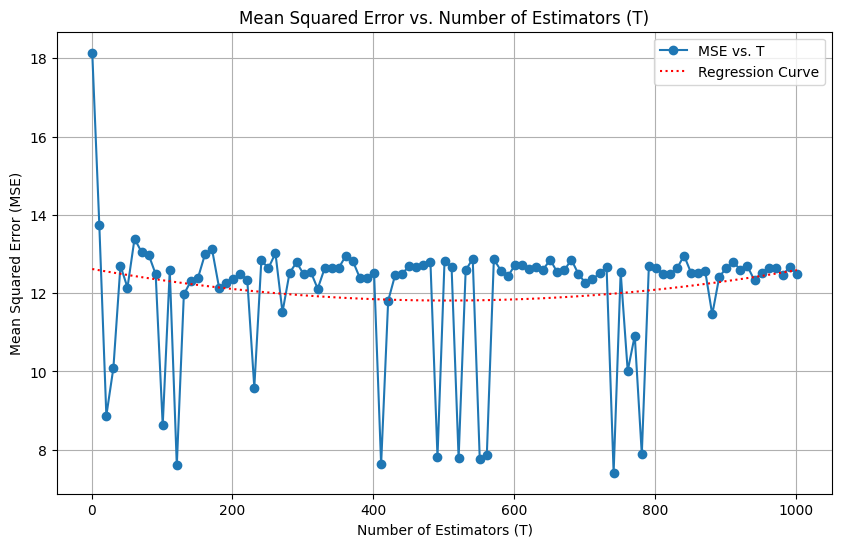

In [43]:
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
mse_values = []
for t in T_values:
    ada_boost_regressor = AdaBoostR2()
    ada_boost_regressor.fit(X_train, y_train, T=t, stub_depth=20, random_state=None)
    y_pred_adaboost = ada_boost_regressor.predict(X_test)
    mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
    mse_values.append(mse_adaboost)

reg_curve_values = regression_curve(T_values, mse_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, mse_values, marker='o', label='MSE vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Mean Squared Error vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Number of Estimators vs Training time

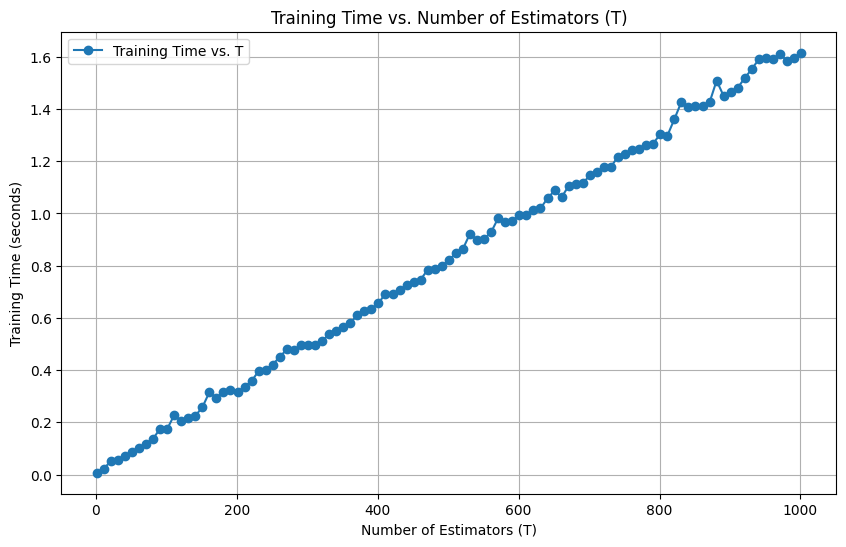

In [45]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    
    ada_boost_regressor = AdaBoostR2()
    ada_boost_regressor.fit(X_train, y_train, T=t, stub_depth=20, random_state=None)
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosted Decision Trees (Regression)

In [46]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X_train, y_train):
        # Step 1: Initial prediction
        initial_prediction = np.mean(y_train)
        predictions = np.full_like(y_train, initial_prediction)

        for _ in range(self.n_estimators):
            # Step 2: Calculate residuals
            residuals = y_train - predictions

            # Step 3: Build a decision tree to predict residuals
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X_train, residuals)

            # Step 4: Combine outputs with learning rate
            prediction_update = self.learning_rate * tree.predict(X_train)
            predictions += prediction_update

            # Store the tree in the list of models
            self.models.append(tree)

    def predict(self, X_test):
        # Step 5: Generate new set of residuals for prediction
        predictions = np.full(X_test.shape[0], np.mean(y_train))

        for tree in self.models:
            # Step 6: Build a decision tree to predict residuals
            prediction_update = self.learning_rate * tree.predict(X_test)

            # Step 7: Combine outputs to form a new set of predictions
            predictions += prediction_update

        # Step 8: Final predictions
        return predictions

# Example usage
# Assuming you have X_train, y_train, X_test
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)
print(mean_squared_error(y_test, y_pred))

7.5896115805132744


### Number of Estimators vs MSE

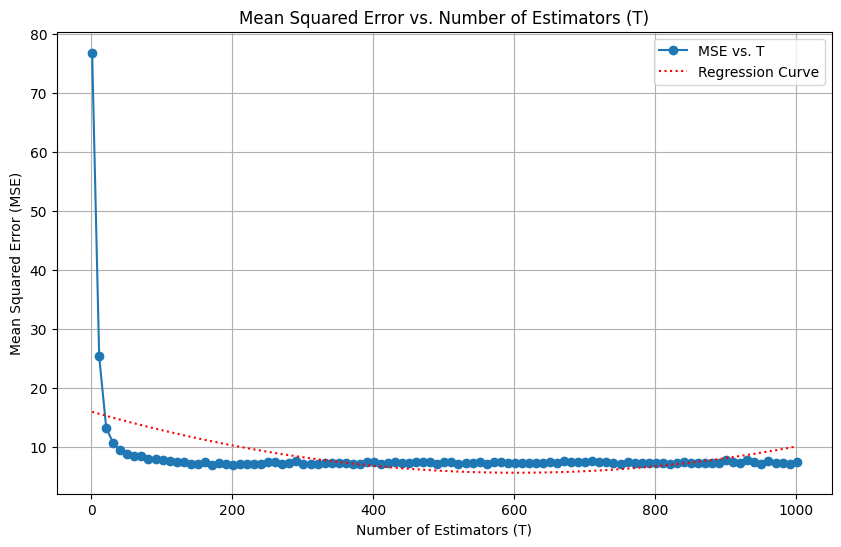

In [48]:
def regression_curve(x, y):
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    return p(x)
T_values = list(range(1, 1002, 10))
mse_values = []
for t in T_values:
    gb_regressor = GradientBoostingRegressor(n_estimators=t, learning_rate=0.1)
    gb_regressor.fit(X_train, y_train)
    y_pred = gb_regressor.predict(X_test)
    mse_gb = mean_squared_error(y_test, y_pred)
    mse_values.append(mse_gb)

reg_curve_values = regression_curve(T_values, mse_values)
plt.figure(figsize=(10, 6))

plt.plot(T_values, mse_values, marker='o', label='MSE vs. T')
plt.plot(T_values, reg_curve_values, linestyle='dotted', color='red', label='Regression Curve')

plt.title('Mean Squared Error vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### Number of Estimators vs Training Time

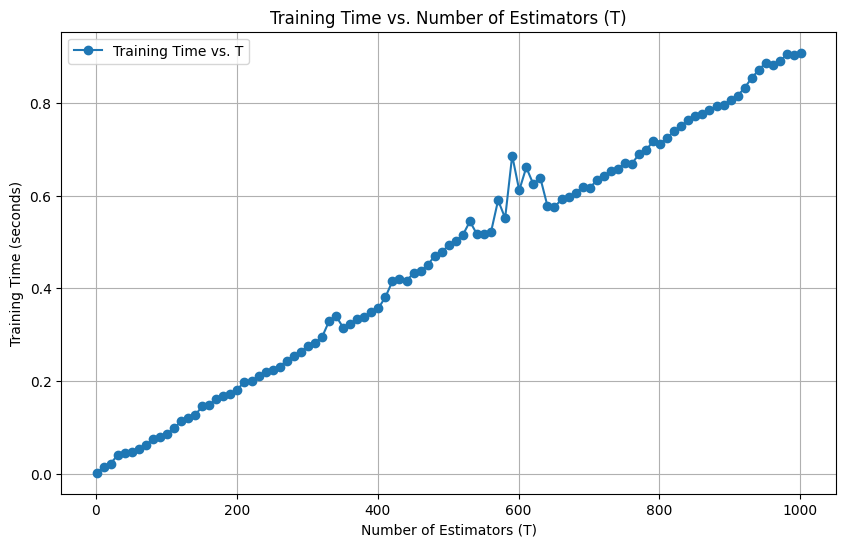

In [49]:
T_values = list(range(1, 1002, 10))
training_times = []

for t in T_values:
    start_time = time.time()
    gb_regressor = GradientBoostingRegressor(n_estimators=t, learning_rate=0.1)
    gb_regressor.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(T_values, training_times, marker='o', label='Training Time vs. T')

plt.title('Training Time vs. Number of Estimators (T)')
plt.xlabel('Number of Estimators (T)')
plt.ylabel('Training Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
data = pd.read_csv('WineQT.csv', header=0)
data['quality'].replace({3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1}, inplace=True)
train_data, test_data = train_test_split(data, test_size=0.2,random_state = 42)

scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

imputer = SimpleImputer(strategy='mean')  

train_data_scaled = scaler.fit_transform(imputer.fit_transform(train_data.drop(columns=['quality'])))
train_labels = train_data['quality']

test_data_scaled = scaler.transform(imputer.transform(test_data.drop(columns=['quality'])))

train_data_scaled_normalized = minmax_scaler.fit_transform(train_data_scaled)
test_data_scaled_normalized = minmax_scaler.transform(test_data_scaled)

X_train = train_data_scaled
y_train = train_labels
X_test = test_data_scaled
y_test = test_data['quality']

y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_test)


[0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1
 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0
 0 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0
 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0
 0 0 0 1 0 1 1]


# Random Forest Classification

In [19]:
def random_forest_ensemble_classification(n_estimators, sample_fraction, with_replacement, voting):
    ensemble_models = []
    
    sample_size = int(sample_fraction * len(X_train))
    for _ in range(n_estimators):
        sample_indices = np.random.choice(len(X_train), size=sample_size, replace=with_replacement)
        sample_X = X_train[sample_indices]  
        sample_y = y_train[sample_indices]
        base_model = DecisionTreeClassifier(max_features="sqrt")
        sample_y = np.array(sample_y)
        base_model.fit(sample_X, sample_y)
        ensemble_models.append(base_model)

    def ensemble_predict(X):
        predictions = [model.predict(X) for model in ensemble_models]
        predictions = np.array(predictions)
        if voting == "hard":
            column_sums = np.sum(predictions, axis=0)
            array_2d = (column_sums > (len(predictions) / 2)).astype(int)
            return array_2d
        elif voting == "soft":
            confidences = [accuracy_score(y_test, model.predict(X_test)) for model in ensemble_models]
            confidences = confidences / sum(confidences)
            prediction = []
            for i in range(len(confidences)):
                prediction.append(predictions[i] * confidences[i])
            prediction = np.array(prediction)
            array_2d = np.sum(prediction, axis=0) > 0.5
            array_2d = array_2d.astype(int)
            return array_2d
    return ensemble_predict

# Example usage for bagging ensemble with Decision Tree classifier and soft voting
bagged_classifier_decision_tree_soft = random_forest_ensemble_classification(n_estimators=10, sample_fraction=0.75, with_replacement=True, voting="hard")

y_pred = bagged_classifier_decision_tree_soft(X_test)
y_pred = np.array(y_pred)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.759825327510917


### Hyperparameter Tuning

In [ ]:
n_estimators = [1,10,50,100,500,1000]
sample_fraction = [0.15,0.25,0.5,0.75,1]
bootstrap = [True,False]
voting = ["soft","hard"]
best_accuracy = 0
best_params = []
for i in n_estimators:
    for k in sample_fraction:
        for l in bootstrap:
            for m in voting:
                bagged_classifier = random_forest_ensemble_classification(n_estimators=i, sample_fraction=k, with_replacement=l, voting=m)
                y_pred = bagged_classifier(X_test)
                y_pred = np.array(y_pred)
                y_test = np.array(y_test)
                acc = accuracy_score(y_test, y_pred)
                print("Accuracy:", acc)
                print("n_estimators:",i)
                print("sample_fraction:",k)
                print("bootstrap:",l)
                print("voting:",m)
                print("-----------------------------------------------------")
                if(acc >= best_accuracy):
                    best_accuracy = acc
                    best_params = [i,k,l,m]
print("Best Accuracy:",best_accuracy)
print("Best Parameters:",best_params)     

## Decision Tree + Adaboost (Classification)

In [242]:
class AdaBoostBinaryClassifier:
    
    def fit(self, X_train, y_train, T, stub_depth=1):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.T = T
        self.stub_depth = stub_depth
        self.weights = np.repeat(1 / self.N, self.N)
        self.classifiers = []
        self.alphas = []
        self.predictions = np.empty((self.N, self.T))
        
        for t in range(self.T):
            # Calculate stuff
            classifier_t = DecisionTreeClassifier(max_depth=self.stub_depth)
            classifier_t.fit(self.X_train, self.y_train, sample_weight=self.weights)
            prediction_t = classifier_t.predict(self.X_train)
            epsilon_t = sum(self.weights * (prediction_t != self.y_train)) / sum(self.weights)
            alpha_t = np.log((1 - epsilon_t) / epsilon_t)
            self.weights = np.array([w * np.exp(alpha_t) if prediction_t[i] != self.y_train[i]
                                     else w * np.exp(-alpha_t) for i, w in enumerate(self.weights)])
            self.weights /= sum(self.weights)
            self.classifiers.append(classifier_t)
            self.alphas.append(alpha_t)
            self.predictions[:, t] = prediction_t
            
        self.y_pred = np.sign(np.dot(self.predictions, self.alphas))
        
    def predict(self, X_test):
        predictions = np.zeros(len(X_test))
        for t, classifier in enumerate(self.classifiers):
            predictions += classifier.predict(X_test) * self.alphas[t]
        return np.sign(predictions)
adaboost_classifier = AdaBoostBinaryClassifier()
adaboost_classifier.fit(X_train, y_train, T=1, stub_depth=1)
y_pred_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("AdaBoost Accuracy:", accuracy_adaboost)

AdaBoost Accuracy: 0.6899563318777293


## Gradient Boosted Decision Tree Classification

In [243]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X_train, y_train):
        initial_prediction = np.log(np.mean(y_train) / (1 - np.mean(y_train)))
        predictions = [initial_prediction]*len(y_train)
        predictions = np.array(predictions)
        for _ in range(self.n_estimators):
            logits = self.sigmoid(predictions)
            residuals = y_train - logits
            residuals = np.array(residuals)
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X_train, residuals)
            prediction_update = self.learning_rate * tree.predict(X_train)
            predictions += prediction_update
            self.models.append(tree)

    def predict_proba(self, X_test):
        predictions = [np.log(np.mean(y_train) / (1 - np.mean(y_train)))]*len(X_test)
        predictions = np.array(predictions)
        for tree in self.models:
            prediction_update = self.learning_rate * tree.predict(X_test)
            predictions += prediction_update
        probabilities = self.sigmoid(predictions)
        return np.column_stack((1 - probabilities, probabilities))

    def predict(self, X_test, threshold=0.5):
        probabilities = self.predict_proba(X_test)[:, 1]
        return (probabilities >= threshold).astype(int)

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_classifier.fit(X_train, y_train)
y_pred_proba = gb_classifier.predict_proba(X_test)
y_pred = gb_classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7729257641921398
